# Decision Trees: Classification

In [1]:
# Importing necessary libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub as kh
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from scipy.stats import randint

## Loading, Defining and Understanding the Data

In [3]:
path = kh.dataset_download("uciml/glass")
df = pd.read_csv(f'{path}/glass.csv')

In [4]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [6]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [7]:
df.duplicated().sum()

np.int64(1)

In [8]:
# Deleting the duplicates
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

np.int64(0)

<Axes: xlabel='Type'>

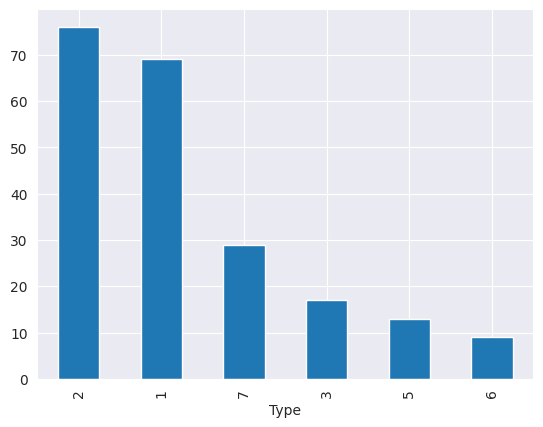

In [10]:
df['Type'].value_counts().plot(kind='bar')

In [11]:
df['Ba'].value_counts()

Ba
0.00    175
0.09      2
0.11      2
1.59      2
0.64      2
1.57      2
0.27      1
0.06      1
0.14      1
0.69      1
2.20      1
0.15      1
0.24      1
1.19      1
1.68      1
1.63      1
0.76      1
3.15      1
0.40      1
0.61      1
0.81      1
0.66      1
0.53      1
0.63      1
0.56      1
1.71      1
0.67      1
1.55      1
1.38      1
2.88      1
0.54      1
1.06      1
1.64      1
1.67      1
Name: count, dtype: int64

### PCA for defining importance of features

In [12]:
# Standardizing the data
scaler = StandardScaler()
df_prep = scaler.fit_transform(df.drop('Type', axis=1))

In [13]:
# Applying PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_prep)

<Axes: xlabel='PCA1', ylabel='PCA2'>

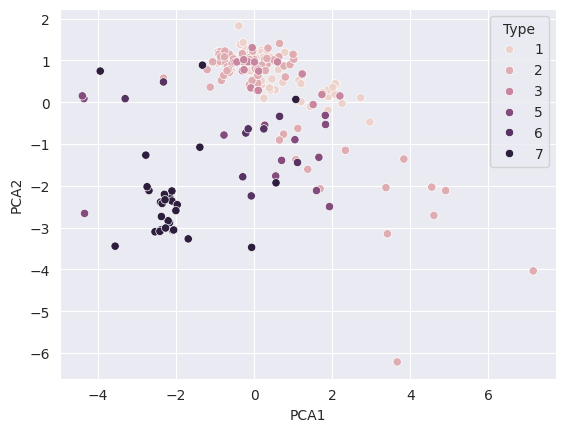

In [14]:
# Plotting the PCA
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_pca['Type'] = df['Type'].values

sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Type')

In [15]:
print(f"Ratio: {pca.explained_variance_ratio_}")

Ratio: [0.2789058  0.22868548]


In [16]:
# Get the PCA components
pca_components = pca.components_

# Create a DataFrame for better readability
pca_df = pd.DataFrame(pca_components, columns=df.drop('Type', axis=1).columns, index=['PCA1', 'PCA2'])

# Display the PCA components
print(pca_df)

            RI        Na        Mg        Al        Si         K        Ca  \
PCA1  0.543223 -0.267614  0.109326 -0.426951 -0.223923 -0.215659  0.492437   
PCA2 -0.289118 -0.269099  0.592155 -0.296363  0.158745  0.153051 -0.346790   

            Ba        Fe  
PCA1 -0.251646  0.191264  
PCA2 -0.482621  0.060892  


## Visualizing the Data

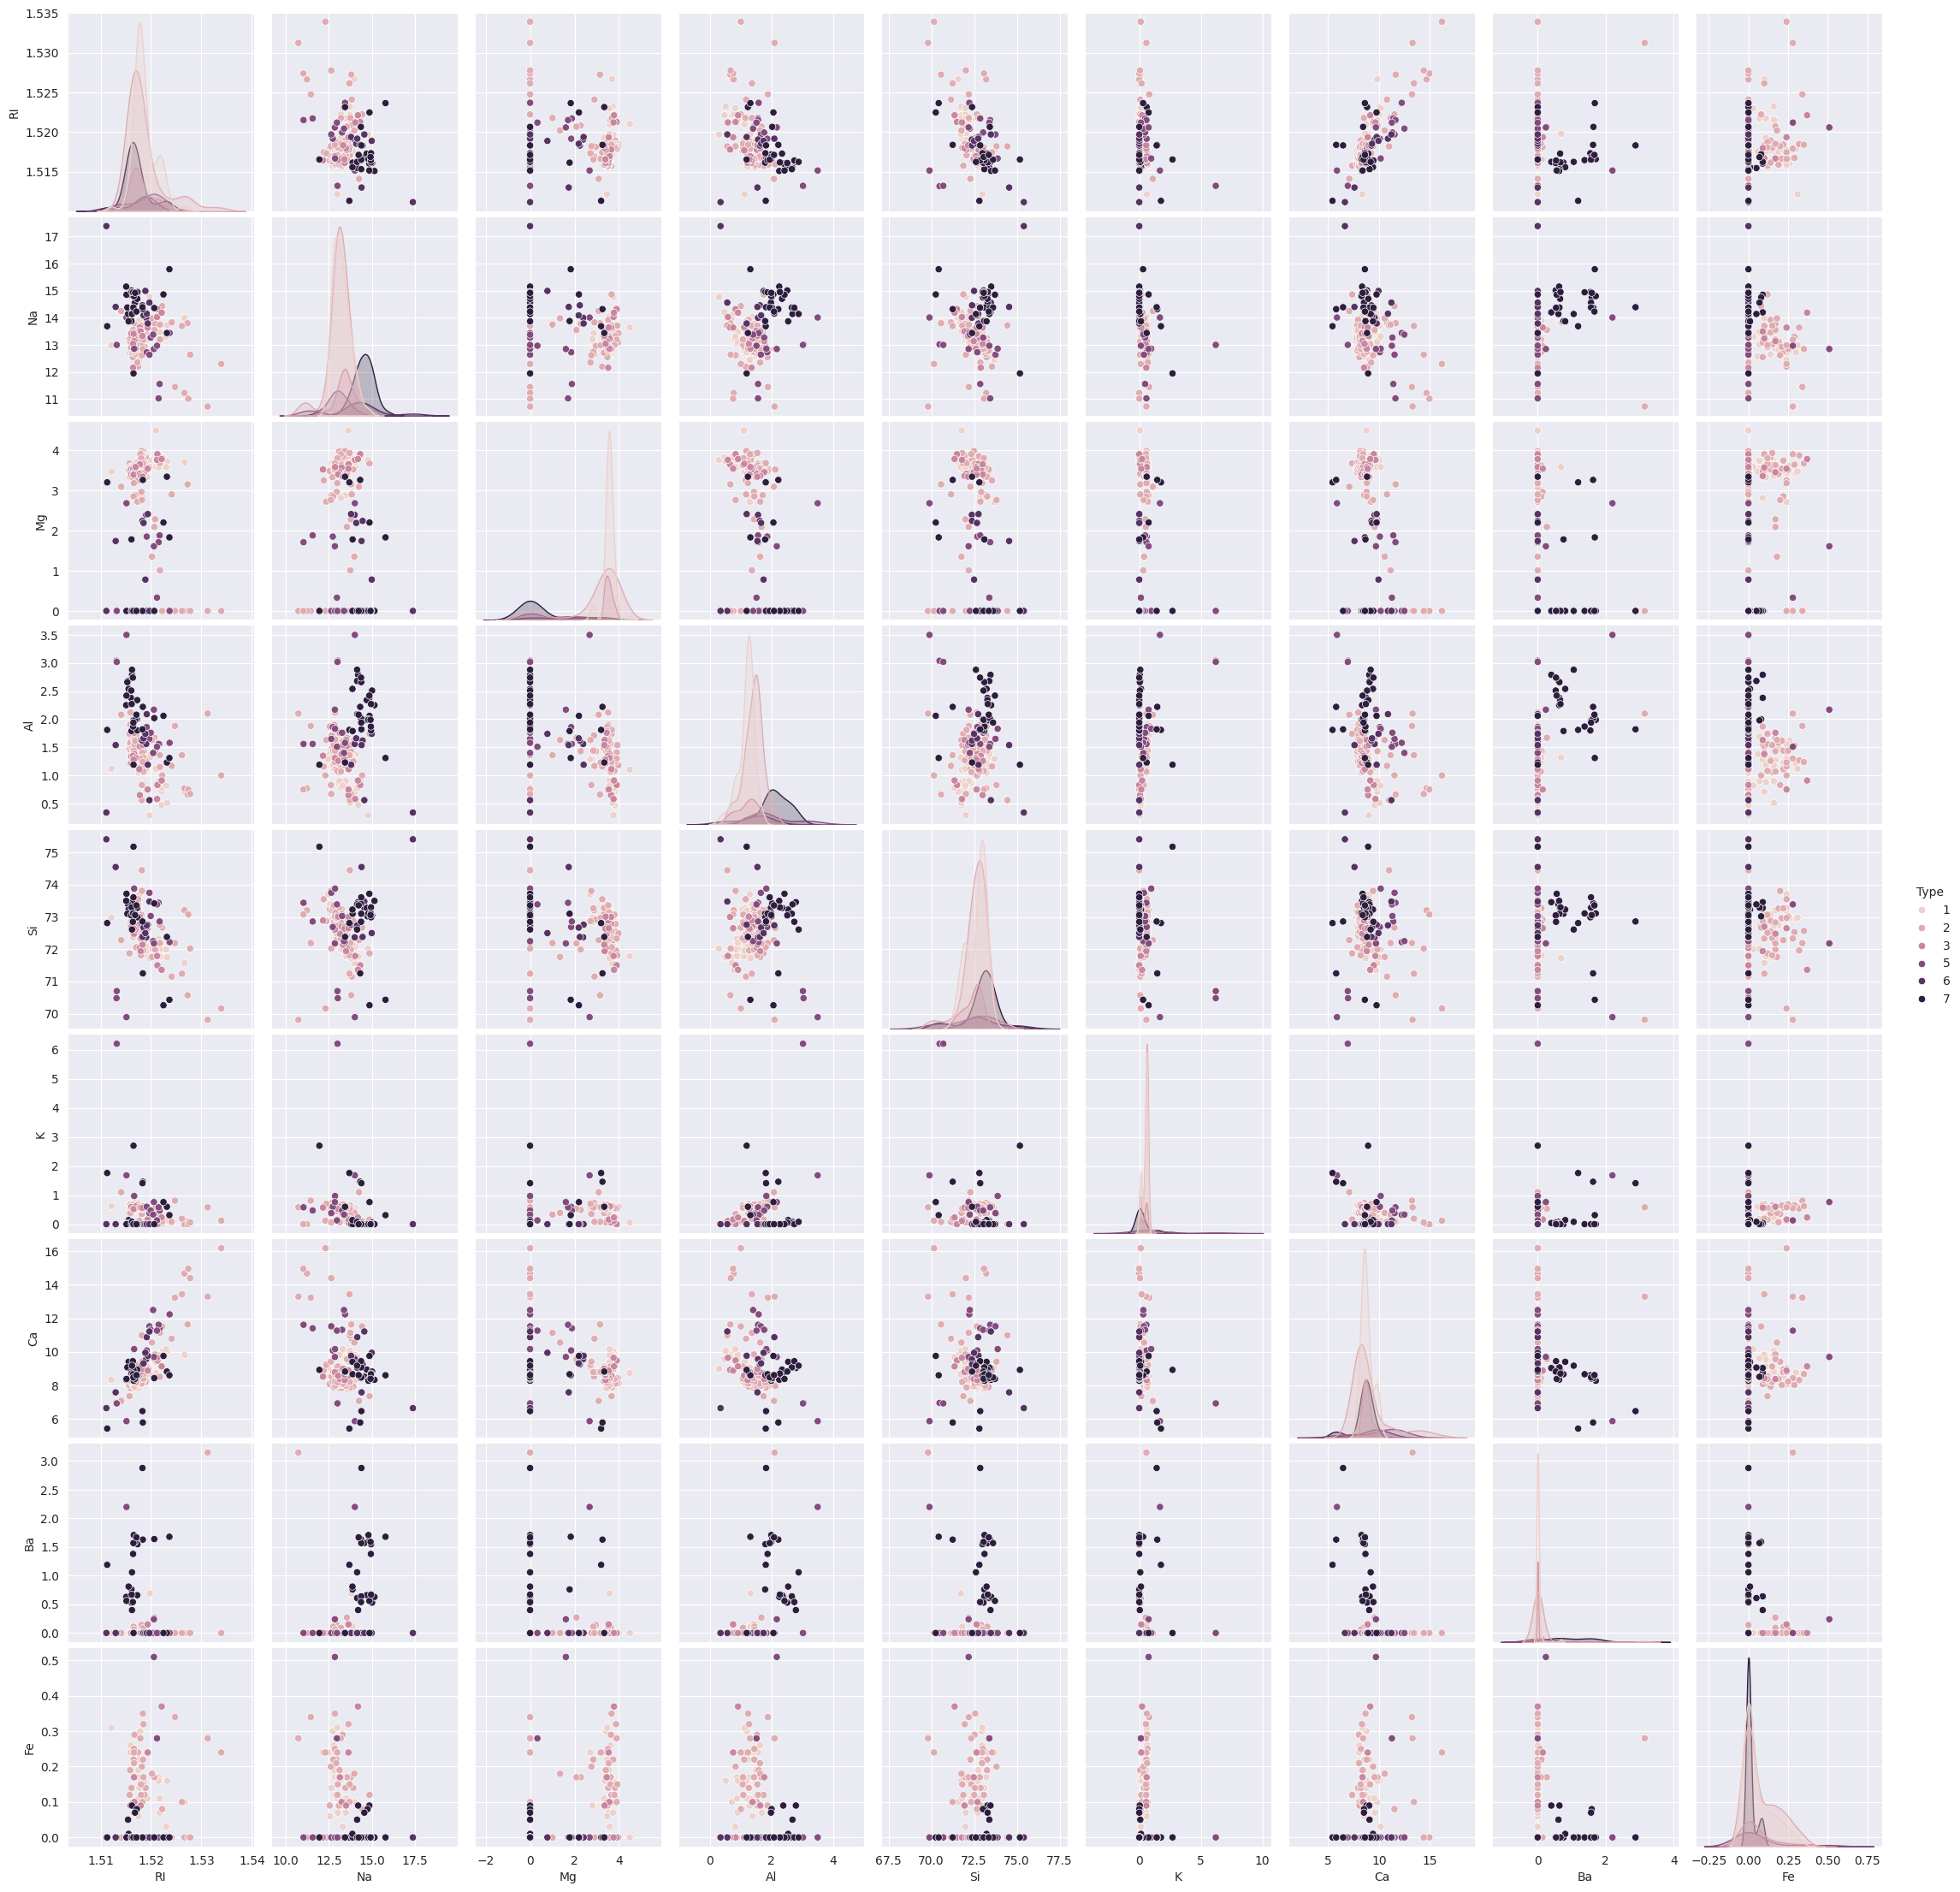

In [17]:
# Pairplot
sns.pairplot(df, hue='Type')

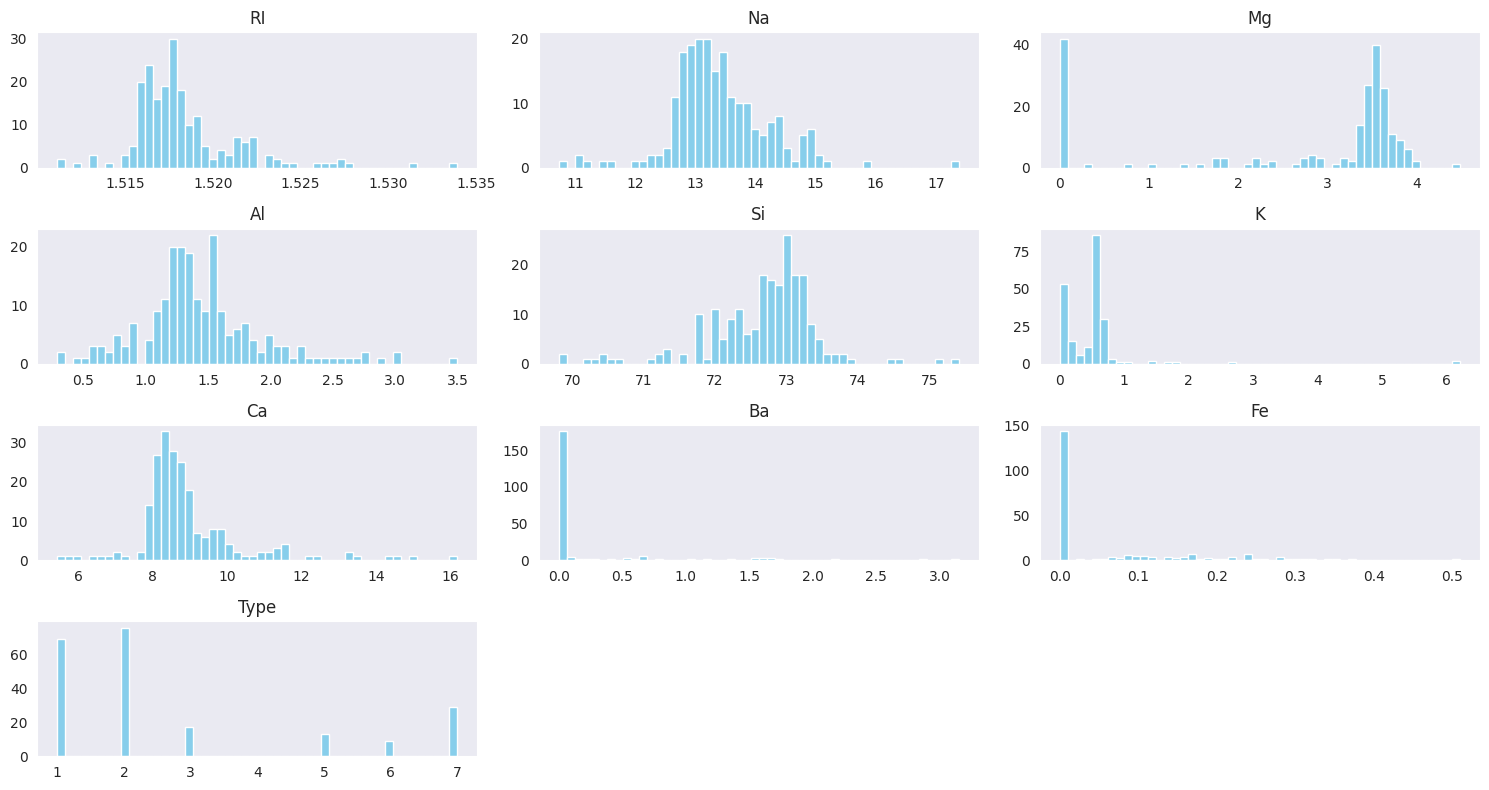

In [18]:
# Histogram
df.hist(figsize=(15, 8), bins=50, grid=False, color='skyblue')
plt.tight_layout()
plt.show()

## Training, Predicting and Evaluating

In [19]:
# Split dataset into X and y
X = df.drop('Type', axis=1)
y = df['Type']

In [20]:
# Split data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Defining the model
dt_clf = DecisionTreeClassifier(
    criterion='gini',
    splitter='random',
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=5,
    random_state=42
)

# Fitting with data
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, random_state=42,
                       splitter='random')

In [22]:
# Predicting with test set
y_pred = dt_clf.predict(X_test)

In [23]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print(accuracy)
print(report)

0.578125
              precision    recall  f1-score   support

           1       0.60      0.83      0.70        18
           2       0.68      0.62      0.65        24
           3       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         3
           7       1.00      0.64      0.78        11

    accuracy                           0.58        64
   macro avg       0.38      0.35      0.35        64
weighted avg       0.60      0.58      0.57        64



## Randomized Search for Hyper Tuning

In [24]:
# Define the parameter distribution
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}

In [25]:
# Initialize the DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=dt_clf, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7edef214c6e0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7edef2129590>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7edef2129310>,
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='accuracy')

In [26]:
# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')

Best Parameters: {'criterion': 'gini', 'max_depth': 19, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 13, 'splitter': 'best'}
Best Score: 0.6648275862068965


In [27]:
# Initialize the DecisionTreeClassifier with the best parameters
dt_clf_best = DecisionTreeClassifier(**best_params)
dt_clf_best.fit(X_train, y_train)

# Predict the test set
y_pred_best = dt_clf_best.predict(X_test)

In [29]:
# Evaluate the model
acc_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best, zero_division=0)

print(f'Accuracy: {acc_best}')
print(f'Report: {report_best}')

Accuracy: 0.71875
Report:               precision    recall  f1-score   support

           1       0.75      0.67      0.71        18
           2       0.72      0.75      0.73        24
           3       0.50      0.50      0.50         4
           5       0.50      1.00      0.67         4
           6       0.00      0.00      0.00         3
           7       0.91      0.91      0.91        11

    accuracy                           0.72        64
   macro avg       0.56      0.64      0.59        64
weighted avg       0.70      0.72      0.70        64

